# Day 6
## Regularization and Normalization
How do regularization layers interact with simple MLP? 

In [1]:
import os
import random

import torch
import torch.nn.functional as F  # noqa: N812
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [2]:
# ---- Configuration ----
DATASET = datasets.FashionMNIST
BATCH_SIZE = 256
EPOCHS = 10
LR = 2e-3
WD = 1e-4
H = 42
COSINE_LR = True # Use cosine learning rate schedule
NUM_WORKERS = 2

from utils import set_seed
set_seed()

## Fashion MNIST data preprocessing

**Fashion MNIST** stores pixel values as unsigned 8-bit integers in the range 0...255. Dividing by 255 converts this to floats in $[0,1]$. Necessary before mean/std normalization. 

In [3]:
import pandas as pd

raw_train = datasets.FashionMNIST(root="./data", train=True,  download=True)
data = raw_train.data.float().div_(255)
mean = data.mean().item()
std = data.std().item()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

# --- Reload datasets with transforms (standard) ---
train_ds = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

# --- Data loaders ---
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"[Data] Mean: {mean}, std: {std}")
print("[Data] Train size:", len(train_ds))
print("[Data] Test size:", len(test_ds))

[Data] Mean: 0.28604060411453247, std: 0.3530242443084717
[Data] Train size: 60000
[Data] Test size: 10000


## Dropout

In [10]:
from nets_numpy import MLP
from constants import DEVICE
from utils import train_epoch, evaluate

dropouts = [0.0, 0.2, 0.4, 0.6, 0.8]
accuracies = {} # dropout -> list of accuracies

for droupout_probability in dropouts:
    print(f"\n\n[Experiment] Dropout probability: {droupout_probability}")

    model = MLP(droupout_probability=droupout_probability,
                use_batchnorm=False).to(device=DEVICE)

    # --- Optimizer ---
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS) if COSINE_LR else None

    # --- Training ---
    best_accuracy = 0.0
    epochs = 10

    for epoch in range(1, epochs + 1):
        train_loss, train_accuracy = train_epoch(model, train_loader, optimizer, loss)
        test_loss, test_accuracy = evaluate(model, test_loader, loss)

        if scheduler: scheduler.step()

        print(f"[Training] Epoch {epoch:2d}/{epochs} | "
          f"Train loss: {train_loss:.4f}, accuracy: {train_accuracy:.4f} | "
          f"Test loss: {test_loss:.4f}, accuracy: {test_accuracy:.4f} | "
          f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}")

        accuracies.setdefault(droupout_probability, []).append(test_accuracy)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save(model.state_dict(), f"fashion_mnist_mlp_best_dropout_{droupout_probability}.pth")
            print(f"[Model] New best model saved with accuracy: {best_accuracy:.4f}")



[Experiment] Dropout probability: 0.0


/Users/vojtahavlicek/onramp/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Training] Epoch  1/10 | Train loss: 0.4908, accuracy: 0.8213 | Test loss: 0.4043, accuracy: 0.8555 | Learning rate: 0.001951
[Model] New best model saved with accuracy: 0.8555
[Training] Epoch  2/10 | Train loss: 0.3496, accuracy: 0.8704 | Test loss: 0.3732, accuracy: 0.8644 | Learning rate: 0.001809
[Model] New best model saved with accuracy: 0.8644
[Training] Epoch  3/10 | Train loss: 0.3048, accuracy: 0.8872 | Test loss: 0.3632, accuracy: 0.8653 | Learning rate: 0.001588
[Model] New best model saved with accuracy: 0.8653
[Training] Epoch  4/10 | Train loss: 0.2762, accuracy: 0.8967 | Test loss: 0.3538, accuracy: 0.8729 | Learning rate: 0.001309
[Model] New best model saved with accuracy: 0.8729
[Training] Epoch  5/10 | Train loss: 0.2546, accuracy: 0.9050 | Test loss: 0.3352, accuracy: 0.8820 | Learning rate: 0.001000
[Model] New best model saved with accuracy: 0.8820
[Training] Epoch  6/10 | Train loss: 0.2298, accuracy: 0.9140 | Test loss: 0.3213, accuracy: 0.8857 | Learning rate

Dropout: 0.0, Accuracies: [0.8555, 0.8644, 0.8653, 0.8729, 0.882, 0.8857, 0.8921, 0.8947, 0.8965, 0.8967]
Dropout: 0.2, Accuracies: [0.8463, 0.8602, 0.8676, 0.8701, 0.8804, 0.8852, 0.8886, 0.8892, 0.8914, 0.8931]
Dropout: 0.4, Accuracies: [0.8395, 0.8526, 0.8643, 0.8672, 0.8693, 0.8742, 0.879, 0.8838, 0.8869, 0.8866]
Dropout: 0.6, Accuracies: [0.8298, 0.8392, 0.8517, 0.8534, 0.8596, 0.8636, 0.8706, 0.8703, 0.8712, 0.8725]
Dropout: 0.8, Accuracies: [0.7694, 0.7932, 0.8047, 0.8114, 0.8189, 0.8197, 0.8277, 0.8344, 0.833, 0.8336]


Text(0.5, 1.0, 'Dropout effect on FashionMNIST')

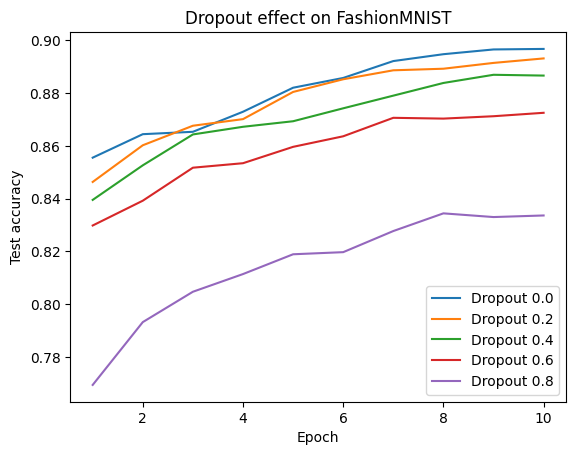

In [11]:
import matplotlib.pyplot as plt

for k, test_accuracies in accuracies.items():
    print(f"Dropout: {k}, Accuracies: {test_accuracies}")

    plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label=f"Dropout {k}")


plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Test accuracy")
plt.title("Dropout effect on FashionMNIST")



#accuracies

## Batchnorm

## Visualisation 

+ Visualisation of loss landscape, similar to https://blog.janestreet.com/visualizing-piecewise-linear-neural-networks/? 
+ https://blog.janestreet.com/visualizing-information-propagation-in-markets-index/